In [1]:
import geopandas as gpd

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import os
import conda

import locale
from datetime import datetime
from IPython.display import HTML
locale.setlocale(locale.LC_ALL, 'en_US.UTF8')

'en_US.UTF8'

In [3]:
pd.set_option('mode.chained_assignment','raise')
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

In [4]:
def get_column_color(column_name):
    v = 'background-color: %s; font-size: %s; font-weight: %s;' % ('#ff677d', '1.2em', 'bold')
    p = 'background-color: %s; font-size: %s; font-weight: %s;' % ('#30e3ca', '1.2em', 'bold')
    if (column_name in ['FULL_PROJECT_NUM', 'CORE_PROJECT_NUM']):
        return v
    elif (column_name in ['ACTIVITY', 'ADMINISTERING_IC', 'APPLICATION_TYPE', 'SERIAL_NUMBER', 'SUPPORT_YEAR']):
        return p
    return ''

def highlight_project_numbers(val):
    return [get_column_color(column_name) for column_name in list(val.index)]

# About NIH awards data

NIH data was imported from [FY 2019 RePORTER Project Data](https://exporter.nih.gov/CSVs/final/RePORTER_PRJ_C_FY2019.zip) and the report listing page [exporter.nih.gov](https://exporter.nih.gov/ExPORTER_Catalog.aspx?sid=5&index=0). An [explanation of the fields](https://exporter.nih.gov/about.aspx) is helpful for analysis.

# Project structure

```bash session
├── NIH-awards.ipynb       # this jupyter notebook
├── data
│   ├── nih                # holds all exporter csv files
│   └── zips               # us-zip-code-latitude-and-longitude.csv
├── out
│   ├── csv                # any csv output
│   ├── json               # any json output
│   └── models             # any saved models
└── utils
    ├── get_csvs           # script to download all the exporter csv files (requires curl)
    └── reporter_files.txt # list of exporter files to get
```

# Import Data

Data preprocessed from `Preprocess.ipynb` and saved in `'./out/csv/post_processed_{ISO_DATE}.csv.gzip'`

In [5]:
df_us_dtypes = {"PI_NAMEs":"string","INDIRECT_COST_AMT":"float64","FY":"int64","CORE_PROJECT_NUM":"object","PHR":"object","ORG_DEPT":"object","FUNDING_ICs":"object","SUPPORT_YEAR":"float64","STUDY_SECTION_NAME":"object","DIRECT_COST_AMT":"float64","ORG_CITY":"object","ORG_DISTRICT":"float64","APPLICATION_TYPE":"float64","PI_IDS":"object","PROJECT_TITLE":"object","ORG_ZIPCODE":"object","ORG_STATE":"object","ORG_NAME":"object","fromfile":"object","ACTIVITY":"object","PROJECT_TERMS":"string","TOTAL_COST":"float64","Longitude":"float64","IC_NAME":"object","ORG_COUNTRY":"object","STUDY_SECTION":"object","NIH_SPENDING_CATS":"object","PROGRAM_OFFICER_NAME":"object","SUBPROJECT_ID":"float64","FUNDING_MECHANISM":"object","ADMINISTERING_IC":"object","TOTAL_COST_SUB_PROJECT":"float64","SERIAL_NUMBER":"float64","SUFFIX":"object","APPLICATION_ID":"int64","FULL_PROJECT_NUM":"object","Latitude":"float64"}

In [8]:
%%time
date_imported = !date -Is
# Important: Providing random sample of 20% of the records from the output of the preprocess notebook.
# For all of the records, re-run the steps in the preprocess notebook and reference the output file here.
# OUT = './out/csv/post_processed_2020-05-14T15:17:56+00:00.csv.gzip' # sample

OUT = './out/csv/post_processed_2020-05-14T15:11:29+00:00.csv.gzip' # full
df_us = pd.read_csv(OUT, parse_dates=["AWARD_NOTICE_DATE","BUDGET_START","BUDGET_END","PROJECT_START","PROJECT_END"], dtype=df_us_dtypes, compression='gzip')
date_imported

CPU times: user 10.4 s, sys: 487 ms, total: 10.9 s
Wall time: 11 s


['2020-05-19T09:22:58+00:00']

In [9]:
df_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167791 entries, 0 to 167790
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   APPLICATION_ID          167791 non-null  int64         
 1   ACTIVITY                167791 non-null  object        
 2   ADMINISTERING_IC        167791 non-null  object        
 3   APPLICATION_TYPE        167791 non-null  float64       
 4   AWARD_NOTICE_DATE       167762 non-null  datetime64[ns]
 5   BUDGET_START            167791 non-null  datetime64[ns]
 6   BUDGET_END              167721 non-null  datetime64[ns]
 7   CORE_PROJECT_NUM        167791 non-null  object        
 8   FULL_PROJECT_NUM        167791 non-null  object        
 9   FUNDING_ICs             167791 non-null  object        
 10  FUNDING_MECHANISM       167791 non-null  object        
 11  FY                      167791 non-null  int64         
 12  IC_NAME                 167791

# Explore the fields

### What are application types? What do they mean?

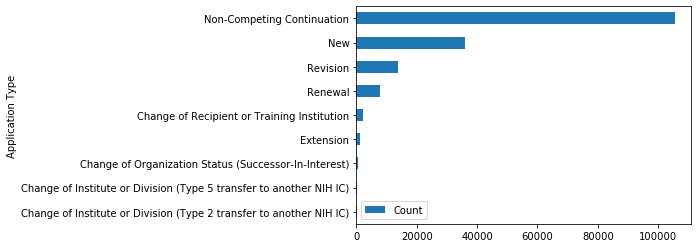

In [10]:
app_types = { 1: 'New', 2: 'Renewal', 3: 'Revision', 4: 'Extension', 5: 'Non-Competing Continuation', 6: 'Change of Organization Status (Successor-In-Interest)', 7: 'Change of Recipient or Training Institution', 8: 'Change of Institute or Division (Type 5 transfer to another NIH IC)', 9: 'Change of Institute or Division (Type 2 transfer to another NIH IC)' }
vals = pd.DataFrame(df_us.APPLICATION_TYPE.value_counts())
vals = vals.apply(lambda x: pd.Series([app_types[np.int(x.name)], x['APPLICATION_TYPE']]), axis=1)
vals.rename(columns={0: "Application Type", 1: "Count"}, inplace=True)
vals.sort_values('Count').plot(x='Application Type', y='Count', kind='barh')

### What do the application types mean? See [NIH explanation of types of applications](https://grants.nih.gov/grants/how-to-apply-application-guide/prepare-to-apply-and-register/type-of-applications.htm) for more information.

  1. New
  2. Renewal
  3. Revision
  4. Extension
  5. **Non-Competing Continuation** *(most common)*
  6. Change of Organization Status (Successor-In-Interest)
  7. Change of Recipient or Training Institution
  8. Change of Institute or Division (Type 5 transfer to another NIH IC)
  9. Change of Institute or Division (Type 2 transfer to another NIH IC) 

# How are awards identified in the dataset? Is there a hierarchy?

### There are 3 identifiers for each award. The [NIH project data page](https://exporter.nih.gov/about.aspx) describes them as:

In [11]:
%%HTML
<style>
:not(.jp-RenderedMarkdown).jp-RenderedHTMLCommon td{text-align:left}.jp-OutputArea-output pre{word-break:normal}table.identifiers{width:60%}table.identifiers tbody tr td{font-size:1.2em}td.yes{border:2px solid #74d4c0}
</style>
<table class="identifiers">
<tr><td><pre>APPLICATION_ID</pre></td><td><strong>A unique identifier</strong> of the project record in the <strong>ExPORTER database</strong></td></tr> 
<tr><td><pre>CORE_PROJECT_NUM</pre></td><td><strong>An identifier for each research project, used to associate the project with publication and patent records</strong>. This identifier is not specific to any particular year of the project. It consists of the project activity code, administering IC, and serial number (a concatenation of Activity, Administering_IC, and Serial_Number).</td></tr>
<tr><td><pre>FULL_PROJECT_NUM</pre></td><td><strong>Commonly referred to as a grant number, intramural project, or contract number</strong>.  For grants, this unique identification number is composed of the type code, activity code, Institute/Center code, serial number, support year, and (optional) a suffix code to designate amended applications and supplements.</td></tr>
</table>

APPLICATION_ID,A unique identifier of the project record in the ExPORTER database
CORE_PROJECT_NUM,"An identifier for each research project, used to associate the project with publication and patent records. This identifier is not specific to any particular year of the project. It consists of the project activity code, administering IC, and serial number (a concatenation of Activity, Administering_IC, and Serial_Number)."
FULL_PROJECT_NUM,"Commonly referred to as a grant number, intramural project, or contract number. For grants, this unique identification number is composed of the type code, activity code, Institute/Center code, serial number, support year, and (optional) a suffix code to designate amended applications and supplements."


# How do full and core project numbers differ?

Lets look at how `FULL_PROJECT_NUM` and `CORE_PROJECT_NUM` are composed. Upon close examination, we can see they are composed of other fields:

In [12]:
%%HTML
<table>
    <tr><th>Identifier</th><th>APPLICATION_TYPE</th><th>ACTIVITY</th><th>ADMINISTERING_IC</th><th>SERIAL_NUMBER</th><th>SUPPORT_YEAR</th><th>SUFFIX</th></tr>
    <tr><td>CORE_PROJECT_NUM</td><td></td><td class="yes">✔</td><td class="yes">✔</td><td class="yes">✔</td><td></td><td></td></tr>
    <tr><td>FULL_PROJECT_NUM</td><td class="yes">✔</td><td class="yes">✔</td><td class="yes">✔</td><td class="yes">✔</td><td class="yes">✔</td><td>optional</td></tr>
</table>

Identifier,APPLICATION_TYPE,ACTIVITY,ADMINISTERING_IC,SERIAL_NUMBER,SUPPORT_YEAR,SUFFIX
CORE_PROJECT_NUM,,✔,✔,✔,,
FULL_PROJECT_NUM,✔,✔,✔,✔,✔,optional


### Lets examine a single with application id `9552833`:

Note the full and core project numbers highlighted in red and their parts highlighted in green.

In [13]:
_example_cols = list(set(df_us.columns) - set(['PROJECT_TERMS']))
_example_cols.sort()
_example = df_us.loc[df_us['APPLICATION_ID'] == 9552833, _example_cols]
_example.style.apply(highlight_project_numbers, axis=1)

,ACTIVITY,ADMINISTERING_IC,APPLICATION_ID,APPLICATION_TYPE,AWARD_NOTICE_DATE,BUDGET_END,BUDGET_START,CORE_PROJECT_NUM,DIRECT_COST_AMT,FULL_PROJECT_NUM,FUNDING_ICs,FUNDING_MECHANISM,FY,IC_NAME,INDIRECT_COST_AMT,Latitude,Longitude,NIH_SPENDING_CATS,ORG_CITY,ORG_COUNTRY,ORG_DEPT,ORG_DISTRICT,ORG_NAME,ORG_STATE,ORG_ZIPCODE,PHR,PI_IDS,PI_NAMEs,PROGRAM_OFFICER_NAME,PROJECT_END,PROJECT_START,PROJECT_TITLE,SERIAL_NUMBER,STUDY_SECTION,STUDY_SECTION_NAME,SUBPROJECT_ID,SUFFIX,SUPPORT_YEAR,TOTAL_COST,TOTAL_COST_SUB_PROJECT,fromfile
69529,P30,EY,9552833,5.000000,2018-07-09 00:00:00,2019-06-30 00:00:00,2018-07-01 00:00:00,P30EY003790,125738.000000,5P30EY003790-37,NEI:247704\,RESEARCH CENTERS,2018,NATIONAL EYE INSTITUTE,121966.000000,42.361792,-71.067740,Biomedical Imaging; Biotechnology; Eye Disease and Disorders of Vision; Genetics; Neurosciences;,BOSTON,UNITED STATES,nan,8.000000,SCHEPENS EYE RESEARCH INSTITUTE,MA,02114,nan,1894531;,"D'AMORE, PATRICIA ANN;",nan,NaT,NaT,Animal Resource Module,3790.000000,ZEY1,Special Emphasis Panel,6636.000000,nan,37.000000,nan,247704.000000,RePORTER_PRJ_C_FY2018.csv


In [14]:
%%HTML
<h3>For Application id <code>9552833</code>, the core and full project numbers are concatenations of the following fields:</h3>
<table>
    <tr><th>Identifier</th><th>APPLICATION_TYPE</th><th>ACTIVITY</th><th>ADMINISTERING_IC</th><th>SERIAL_NUMBER</th><th>SUPPORT_YEAR</th><th>SUFFIX</th></tr>
    <tr><td>CORE_PROJECT_NUM</td><td></td><td class="yes">P30</td><td class="yes">EY</td><td class="yes">003790</td><td></td><td></td></tr>
    <tr><td>FULL_PROJECT_NUM</td><td class="yes">5</td><td class="yes">P30</td><td class="yes">EY</td><td class="yes">003790</td><td class="yes">37</td><td>NaN</td></tr>
</table>

Identifier,APPLICATION_TYPE,ACTIVITY,ADMINISTERING_IC,SERIAL_NUMBER,SUPPORT_YEAR,SUFFIX
CORE_PROJECT_NUM,,P30,EY,003790,,
FULL_PROJECT_NUM,5,P30,EY,003790,37,NaN


In [15]:
duplicated_core_project_numbers = df_us.duplicated("CORE_PROJECT_NUM", keep=False)
duplicated_full_project_numbers = df_us.duplicated("FULL_PROJECT_NUM", keep=False)
dup_core = df_us.loc[duplicated_core_project_numbers]
dup_full = df_us.loc[duplicated_full_project_numbers]
unique_core = pd.unique(df_us.loc[:, 'CORE_PROJECT_NUM'])
unique_full = pd.unique(df_us.loc[:, 'FULL_PROJECT_NUM'])

ldf = len(df_us)

display(HTML(f'<h1>Project number statistics of all ({len(df_us)} awards)</h1>'))
display(HTML(f'<p><strong>{"{:.2%}".format(len(dup_core) / ldf)}</strong> ({len(dup_core)}) awards have duplicate <code>CORE_PROJECT_NUM</code></p>'))
display(HTML(f'<p><strong>{"{:.2%}".format(len(dup_full) / ldf)}</strong> ({len(dup_full)}) awards have duplicate <code>FULL_PROJECT_NUM</code></p>'))
display(HTML(f'<p>There are <strong>{len(unique_core)}</strong> unique <strong>research projects</strong> or unique values for <code>CORE_PROJECT_NUM</code></p>'))
display(HTML(f'<p>There are <strong>{len(unique_full)}</strong> unique <strong>grant numbers</strong> or unique values for <code>FULL_PROJECT_NUM</code></p>'))

# Does each award with a grant number belong to a research project?

### Define two sets, let

- **UC** be the set of application IDs that reference a unique `CORE_PROJECT_NUM`
- **UF** be the set of application IDs that reference a unique `FULL_PROJECT_NUM`
- **AA** be all the application IDs

In [16]:
UC = set(df_us.loc[df_us['CORE_PROJECT_NUM'].isin(unique_core), 'APPLICATION_ID'].to_numpy())
UF = set(df_us.loc[df_us['FULL_PROJECT_NUM'].isin(unique_full), 'APPLICATION_ID'].to_numpy())
AA = set(df_us['APPLICATION_ID'].to_numpy())

In [17]:
print(UC <= AA)
print(UF <= AA)
print(UC <= UF)

True
True
True


### Verify that each grant number belongs to exactly one core project

Group all of the grant numbers `FULL_PROJECT_NUM` and aggregate the unique count of project numbers `CORE_PROJECT_NUM`. If each grant belongs to exactly one project, then the number of unique project numbers should always be 1.

In [18]:
full_agg = df_us.groupby('FULL_PROJECT_NUM').agg({"CORE_PROJECT_NUM": "nunique"})
len(full_agg.loc[full_agg['CORE_PROJECT_NUM'] == 1]) == len(full_agg)

True

### What does this tell us?

There is a 1:M relationship from research project -> grant. That is, each award has a grant number and that grant number has one parent research project (core project number). The vast majority of grants come from the same organization and from the the same zipcode

# What do the cost fields tell us?

In [19]:
# Create a new dataframe, core_projects that groups by research projects and aggregates their costs.
core_projects = df_us.groupby('CORE_PROJECT_NUM').agg({ 'BUDGET_START' : min, 'BUDGET_END' : max, 'DIRECT_COST_AMT': sum, 'TOTAL_COST': sum, 'INDIRECT_COST_AMT': sum, 'TOTAL_COST_SUB_PROJECT': sum, 'ORG_NAME': "first" })

In [20]:
%%HTML
<h3>Costs are defined in across different fields:</h3>
<table class="identifiers">
<tr><td><pre>DIRECT_COST_AMT</pre></td><td>Total direct cost funding for a project from all NIH Institute and Centers for a given fiscal year. Costs are available only for NIH awards funded in FY 2012 onward. Direct cost amounts are not available for SBIR/STTR awards.</td></tr> 
<tr><td><pre>INDIRECT_COST_AMT</pre></td><td>Total indirect cost funding for a project from all NIH Institute and Centers for a given fiscal year. Costs are available only for NIH awards funded in FY 2012 and onward. Indirect cost amounts are not available for SBIR/STTR awards.</td></tr>
<tr><td><pre>TOTAL_COST</pre></td><td>Total project funding from all NIH Institute and Centers for a given fiscal year. Costs are available only for:
    <ul>
        <li>NIH, CDC, FDA, and ACF grant awards (only the parent record of multi-project grants).</li>
        <li>NIH intramural projects (activity codes beginning with “Z”) in FY 2007 and later fiscal years.</li>
        <li>NIH contracts (activity codes beginning with “N”).</li>
    </ul>
</td></tr>
<tr><td><pre>TOTAL_COST_SUB_PROJECT</pre></td><td>Applies to subproject records only.  Total funding for a subproject from all NIH Institute and Centers for a given fiscal year.  Costs are available only for NIH awards.</td></tr>
</table>

DIRECT_COST_AMT,Total direct cost funding for a project from all NIH Institute and Centers for a given fiscal year. Costs are available only for NIH awards funded in FY 2012 onward. Direct cost amounts are not available for SBIR/STTR awards.
INDIRECT_COST_AMT,Total indirect cost funding for a project from all NIH Institute and Centers for a given fiscal year. Costs are available only for NIH awards funded in FY 2012 and onward. Indirect cost amounts are not available for SBIR/STTR awards.
TOTAL_COST,"Total project funding from all NIH Institute and Centers for a given fiscal year. Costs are available only for: NIH, CDC, FDA, and ACF grant awards (only the parent record of multi-project grants). NIH intramural projects (activity codes beginning with “Z”) in FY 2007 and later fiscal years. NIH contracts (activity codes beginning with “N”)."
TOTAL_COST_SUB_PROJECT,Applies to subproject records only. Total funding for a subproject from all NIH Institute and Centers for a given fiscal year. Costs are available only for NIH awards.


In [21]:
D = set(core_projects.loc[core_projects['DIRECT_COST_AMT'] > 0].index)
I = set(core_projects.loc[core_projects['INDIRECT_COST_AMT'] > 0].index)
T = set(core_projects.loc[core_projects['TOTAL_COST'] > 0].index)
S = set(core_projects.loc[core_projects['TOTAL_COST_SUB_PROJECT'] > 0].index)
A = set(core_projects.index)

In [22]:
print(f'There are {len(A)} total research projects')
print(f'All but {len(A - D)} have a direct cost')
print('Research projects with an indirect cost are (almost) a proper subset of projects with a direct cost')
len(I - D) < 2

There are 73856 total research projects
All but 3692 have a direct cost
Research projects with an indirect cost are (almost) a proper subset of projects with a direct cost


True

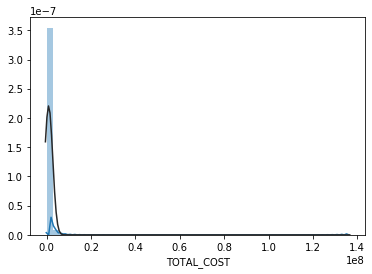

In [23]:
from scipy.stats import norm
ax = sns.distplot(core_projects.loc[:, 'TOTAL_COST'], fit=norm)

In [24]:
current = df_us.copy()
current['year'] = current.loc[:, 'BUDGET_START'].dt.year
current['month'] = current.loc[:, 'BUDGET_START'].dt.month
current = current.loc[current['year'] > 2017]
current['IC_NAME'] = current['IC_NAME'].str.title()

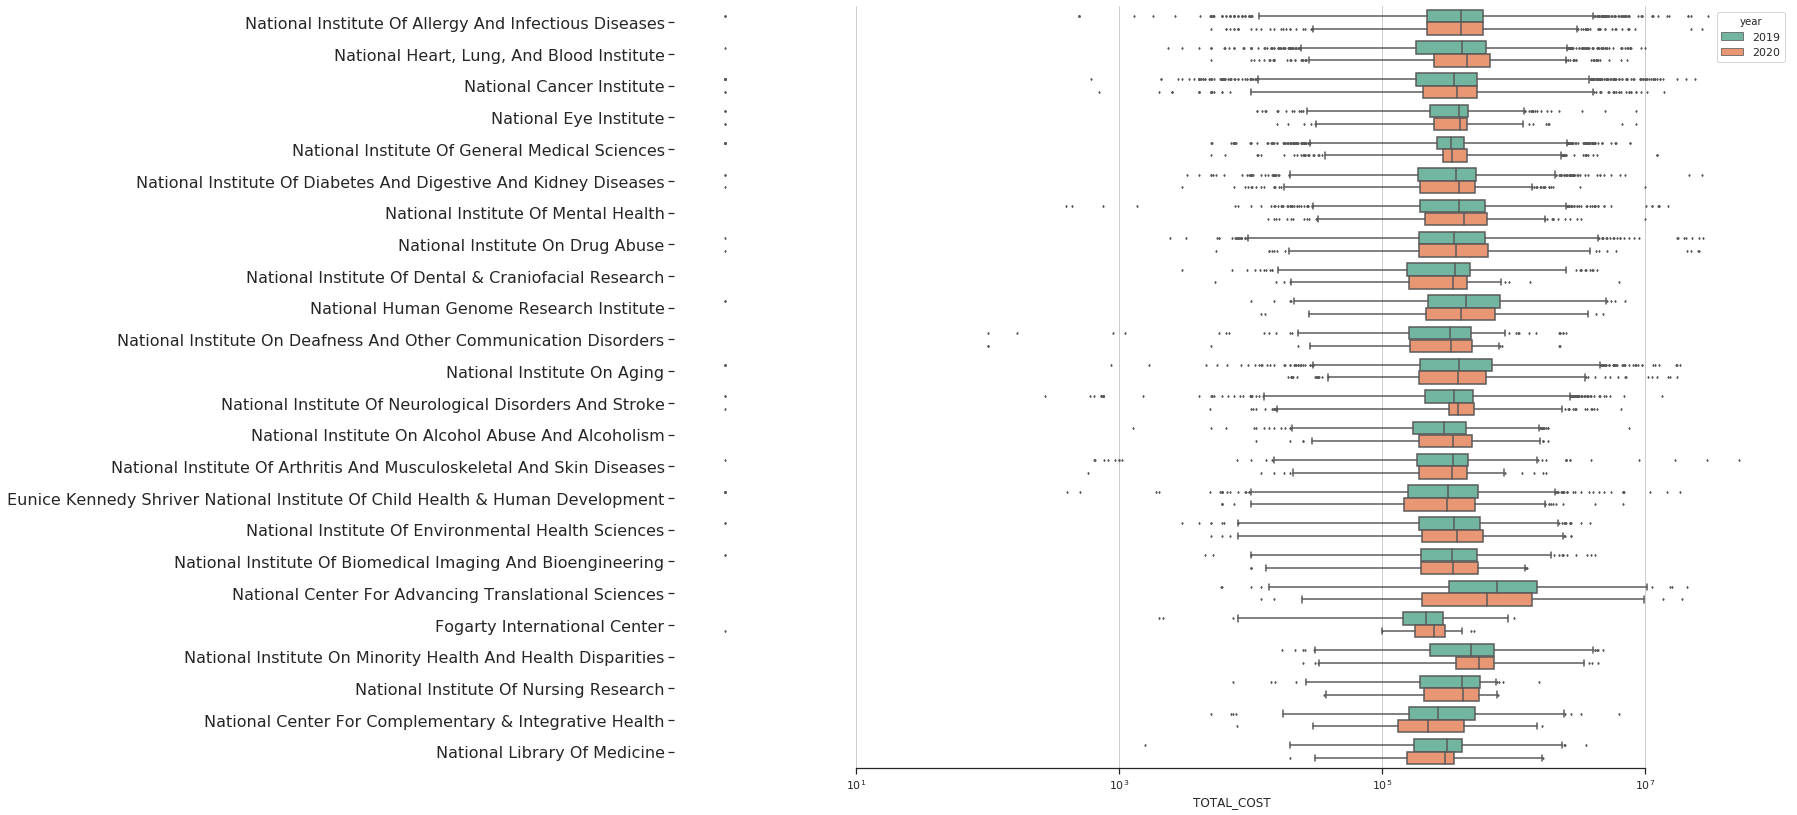

In [25]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(20, 14))
ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot(x="TOTAL_COST", y="IC_NAME", hue="year", data=current.loc[(current['year'].isin([2019,2020]))],
            whis=[1, 99], fliersize=1.5, palette="Set2", ax=ax)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.tick_params(axis='y', labelsize=16)
sns.despine(trim=True, left=True)

In [26]:
%%time
all_centers = current['IC_NAME'].unique()
centers = all_centers[[0,1,4,16,17]]

CPU times: user 32.1 ms, sys: 5.61 ms, total: 37.7 ms
Wall time: 37.6 ms


In [27]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('${x:,.0f}')

def plot_rolling_average(legend, ax):
    _totals = current.loc[current['IC_NAME'] == legend, ['BUDGET_START', 'TOTAL_COST']].sort_values(by='BUDGET_START', ascending=True)
    _p = _totals.rolling(pd.Timedelta('30days'), on='BUDGET_START').median()
    sns.lineplot(x='BUDGET_START', y='TOTAL_COST', data=_p, palette="tab10", linewidth=1, ax=ax)
    ax.set_title(legend)
    ax.set_ylabel("")
    ax.set_xlabel("Budget Start Date")
    ax.tick_params(axis='x', rotation=25, labelsize=7)
    ax.yaxis.set_major_formatter(formatter)
    ax.tick_params(axis='y', labelsize=7)

CPU times: user 51.8 s, sys: 204 ms, total: 52 s
Wall time: 52.1 s


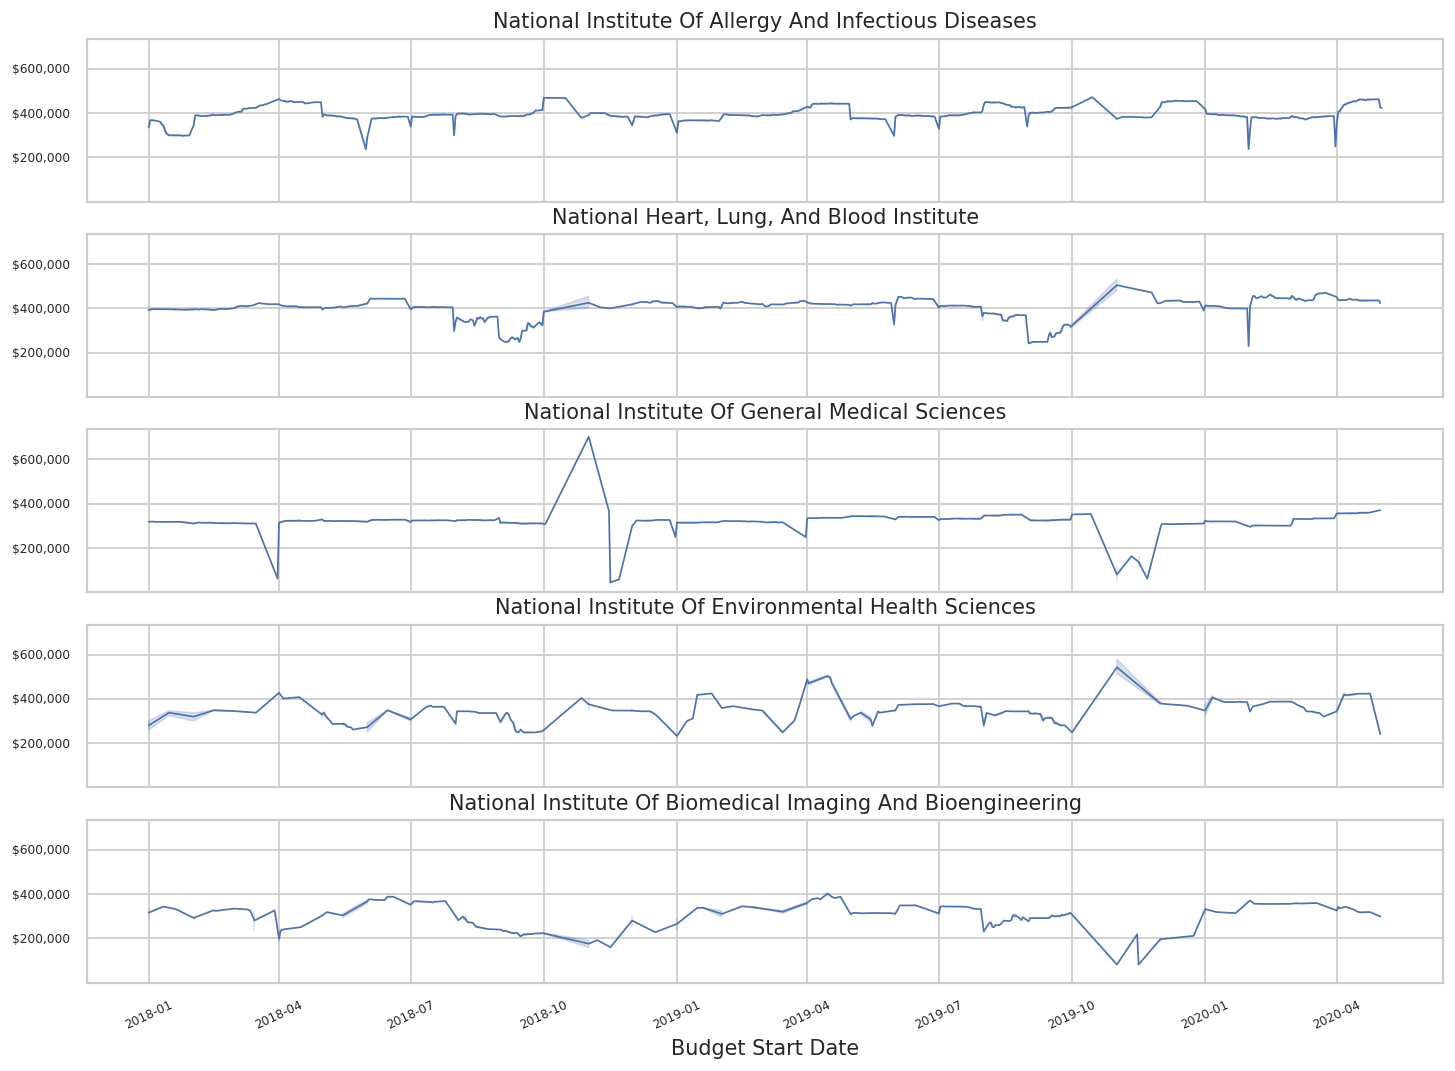

In [28]:
%%time
sns.set(style="whitegrid")

display(HTML('<h1>Trend analysis</h1><p>To analyze trends in funding we look at the moving median since the data are not normally distributed and median is more robust.'))

fig, axs = plt.subplots(len(centers), 1, figsize=(14, len(centers) * 2), dpi=125, constrained_layout=False, sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    plot_rolling_average(centers[i], ax)

CPU times: user 3.77 s, sys: 7.97 ms, total: 3.78 s
Wall time: 3.78 s


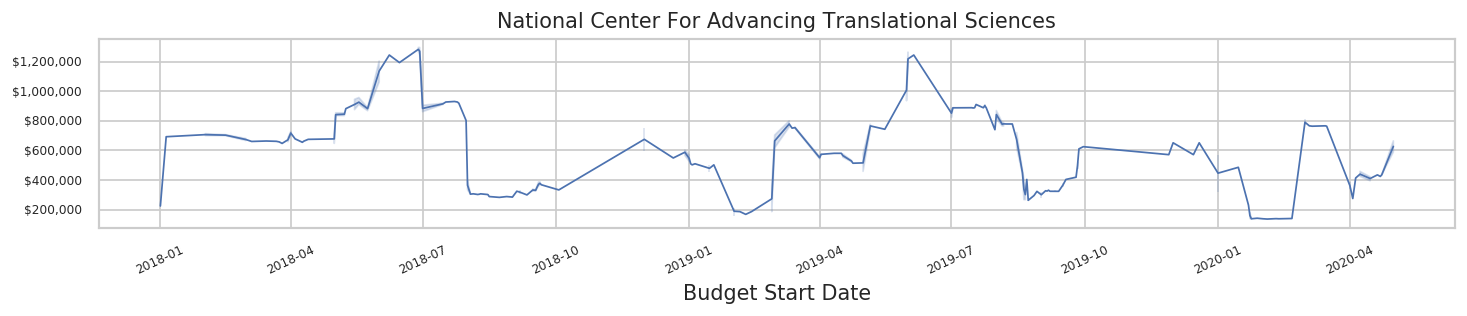

In [29]:
%%time
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 1, figsize=(14, 2), dpi=125, constrained_layout=False, sharex=True, sharey=True)
plot_rolling_average(all_centers[18], axs)

In [30]:
_df = df_us.loc[df_us['BUDGET_START'].dt.year > 2017]

In [31]:
_df = _df.copy()

In [32]:
def get_activity_type(x):
    if x['ACTIVITY'] in [ "R01", "R03", "R13", "R15", "R21", "R34", "R41", "R42", "R43", "R44", "R56", "K99", "R00", "U01" ]:
        return 'Research Project'
    elif x['ACTIVITY'] in [ "P01", "P20", "P30", "P50" ]:
        return 'Program Project/Center Grants'
    elif x['ACTIVITY'] in [ "R24", "R25", "X01" ]:
        return 'Resource Grants'
    else:
        return 'Other'

In [33]:
%%time
_df['ACTIVITY_TYPE'] = _df.apply(lambda x: get_activity_type(x), axis=1)

CPU times: user 28.9 s, sys: 213 ms, total: 29.1 s
Wall time: 29.1 s


In [36]:
print(gpd.datasets.available)
census_shapefile = "./data/nih/cb_2019_us_state_500k.shp"

['naturalearth_lowres', 'naturalearth_cities', 'nybb']


In [38]:
!python -m pip install descartes

In [115]:
grants = gpd.GeoDataFrame(df_us, geometry=gpd.points_from_xy(df_us.Longitude, df_us.Latitude))
grants.crs = {'init': 'epsg:4326'}

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [116]:
us_map

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,12,00294478,0400000US12,12,FL,Florida,00,138947364717,31362872853,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."
1,78,01802710,0400000US78,78,VI,United States Virgin Islands,00,348021896,1550236199,"MULTIPOLYGON (((-64.62799 17.78933, -64.62717 ..."
2,30,00767982,0400000US30,30,MT,Montana,00,376966832749,3869031338,"POLYGON ((-116.04914 48.50205, -116.04913 48.5..."
3,27,00662849,0400000US27,27,MN,Minnesota,00,206230065476,18942261495,"MULTIPOLYGON (((-89.59206 47.96668, -89.59147 ..."
4,24,01714934,0400000US24,24,MD,Maryland,00,25151726296,6979340970,"MULTIPOLYGON (((-76.05015 37.98691, -76.04998 ..."
5,45,01779799,0400000US45,45,SC,South Carolina,00,77864659170,5075874513,"MULTIPOLYGON (((-79.50795 33.02008, -79.50713 ..."
6,23,01779787,0400000US23,23,ME,Maine,00,79887659040,11745717739,"MULTIPOLYGON (((-67.32259 44.61160, -67.32174 ..."
7,15,01779782,0400000US15,15,HI,Hawaii,00,16634006436,11777792811,"MULTIPOLYGON (((-156.06076 19.73055, -156.0566..."
8,11,01702382,0400000US11,11,DC,District of Columbia,00,158340389,18687196,"POLYGON ((-77.11976 38.93434, -77.11253 38.940..."
9,69,01779809,0400000US69,69,MP,Commonwealth of the Northern Mariana Islands,00,472292529,4644252458,"MULTIPOLYGON (((146.05103 16.00674, 146.05167 ..."


In [143]:
west_limit = np.floor(grants.loc[grants['ORG_STATE'] == 'CA', 'Longitude'].min())

In [146]:
east_limit = np.ceil(grants.loc[grants['ORG_STATE'] == 'ME', 'Longitude'].max())

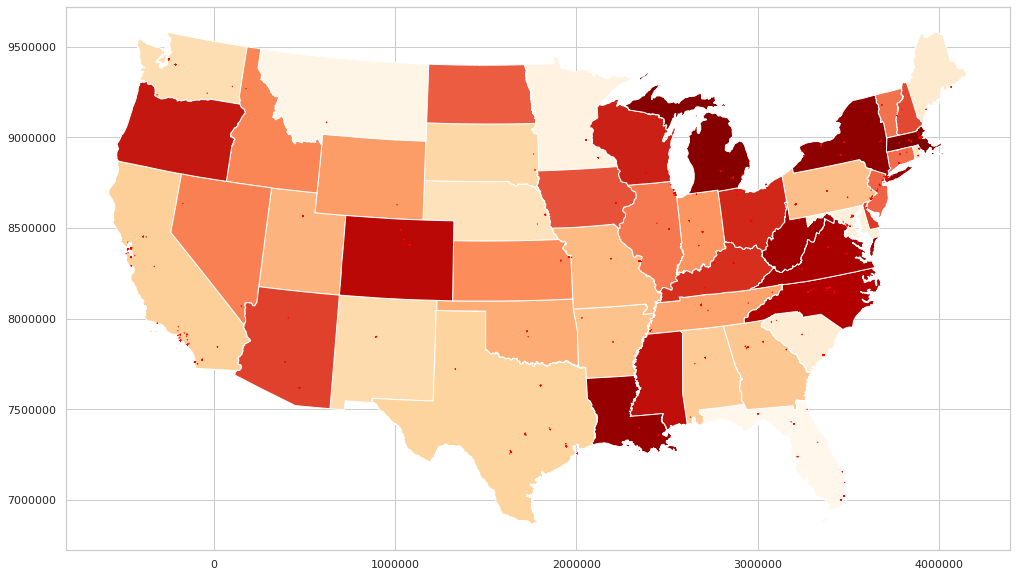

In [151]:
us_map = gpd.read_file(census_shapefile)
us_map.STATEFP = us_map.STATEFP.astype(np.int32)

fig, ax = plt.subplots(figsize=[24,10])
# raw cartesian 
epsg = 3085 # texas albers

us_map.loc[~(us_map['STATEFP'].isin([78,66,69,60,15,72,2]))].to_crs(epsg=epsg).plot(ax=ax, cmap='OrRd')
sample = grants.sample(n=2000)
sample.loc[(sample['Longitude'] >= west_limit) & (sample['Longitude'] <= east_limit)].to_crs(epsg=epsg).plot(markersize=0.7, linestyle=':', color='red', ax=ax)

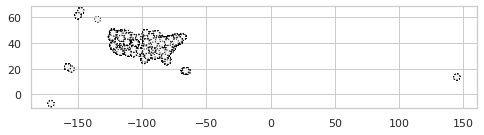

In [282]:
ax = grants.plot(figsize=(8,8), color='whitesmoke', linestyle=':', edgecolor='black')

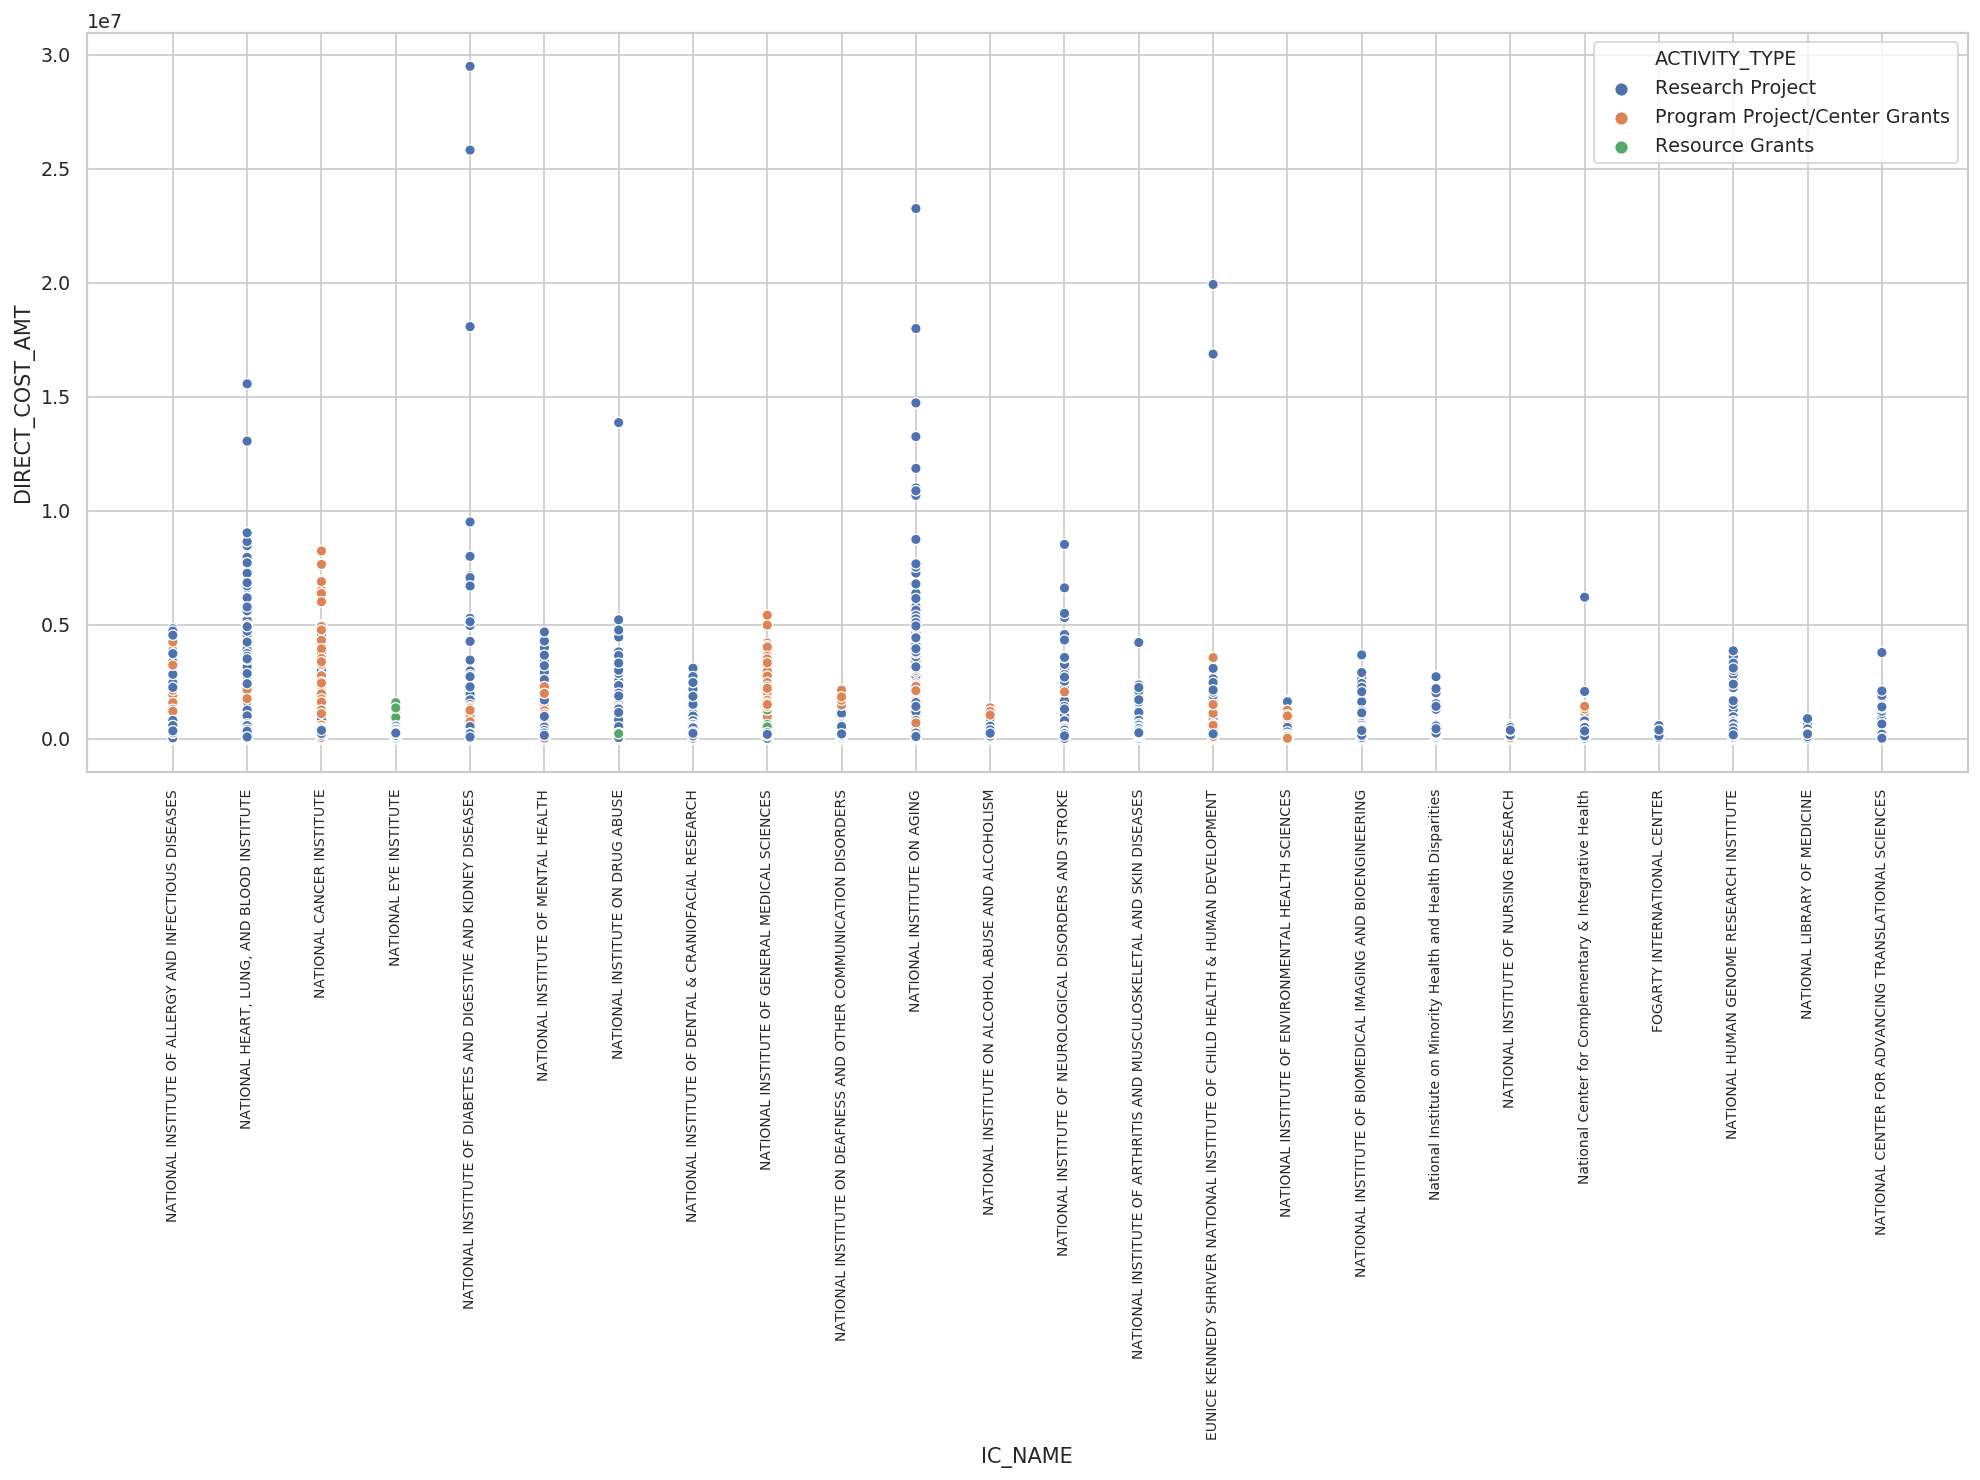

In [276]:
fig, axs = plt.subplots(1, 1, figsize=(16, 12), dpi=125, tight_layout=True)
sns.scatterplot(y='DIRECT_COST_AMT', x='IC_NAME', data=_df.loc[(_df['ACTIVITY_TYPE'] != 'Other')], ax=axs, hue='ACTIVITY_TYPE')
axs.tick_params(axis='x', rotation=90, labelsize=8)

In [113]:
def getDictionary(key, _df):
    """
    Return a tuple with a key and dictionary, which is 
    suitable for replacing redundant dataframe values with `df.replace`
    """
    tmp = pd.Series(_df[key].value_counts(dropna=False)).reset_index()
    tmp_dict = tmp['index'].to_dict()
    return (key, { value:key for key, value in tmp_dict.items() })

In [114]:
replaced = dict([getDictionary('ED_INST_TYPE', df_min), 
                 getDictionary('FUNDING_MECHANISM', df_min), 
                 getDictionary('IC_NAME', df_min), 
                 getDictionary('ORG_CITY', df_min), 
                 getDictionary('ORG_DEPT', df_min), 
                 getDictionary('ORG_NAME', df_min)])

In [115]:
largest_awards = df_min.sort_values(by=['TOTAL_COST'], ascending=False)

In [116]:
largest_awards.head()

,APPLICATION_ID,ED_INST_TYPE,FUNDING_MECHANISM,IC_NAME,ORG_CITY,ORG_DEPT,ORG_NAME,ORG_STATE,ORG_ZIPCODE,PROJECT_START,PROJECT_END,PROJECT_TITLE,SUPPORT_YEAR,DIRECT_COST_AMT,INDIRECT_COST_AMT,TOTAL_COST,Latitude,Longitude
40945,10045910,NaN,Non SBIR/STTR Contracts,NATIONAL CANCER INSTITUTE,frederick,NaN,"LEIDOS BIOMEDICAL RESEARCH, INC.",MD,21702,2019-08-31,2020-08-30,NCI-Frederick Operational Support,NaN,NaN,NaN,66056055.0,39.451934,-77.442000
75798,10045914,NaN,Non SBIR/STTR Contracts,NATIONAL CANCER INSTITUTE,frederick,NaN,"LEIDOS BIOMEDICAL RESEARCH, INC.",MD,21702,2019-09-30,2024-09-29,MD NET,NaN,NaN,NaN,54828827.0,39.451934,-77.442000
62847,9898044,SCHOOLS OF PUBLIC HEALTH,OTHER RESEARCH-RELATED,NATIONAL INSTITUTE OF ARTHRITIS AND MUSCULOSKE...,chapel hill,BIOSTATISTICS & OTHER MATH SCI,UNIV OF NORTH CAROLINA CHAPEL HILL,NC,27599,2019-09-26,2024-05-31,Back Pain Consortium (BACPAC) Research Program...,1.0,41327976.0,10453327.0,51781303.0,36.052510,-79.107692
73969,10038603,NaN,Non SBIR/STTR Contracts,NATIONAL CANCER INSTITUTE,frederick,NaN,"LEIDOS BIOMEDICAL RESEARCH, INC.",MD,21702,2019-08-31,2020-08-30,Division of Cancer Tratment and DIagnosis- Ope...,NaN,NaN,NaN,44232439.0,39.451934,-77.442000
40755,9605111,NaN,Non-SBIR/STTR RPGs,NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS D...,durham,NaN,FAMILY HEALTH INTERNATIONAL,NC,27701,2006-06-01,2020-11-30,LOC: HIV Prevention Trials Network,13.0,40185848.0,2239329.0,42425177.0,35.997193,-78.897310


In [134]:
largest_awards['ORG_NAME'].value_counts()[0:10]

JOHNS HOPKINS UNIVERSITY                   2155
UNIVERSITY OF PENNSYLVANIA                 2010
UNIVERSITY OF CALIFORNIA, SAN FRANCISCO    2010
UNIVERSITY OF MICHIGAN AT ANN ARBOR        1887
UNIVERSITY OF PITTSBURGH AT PITTSBURGH     1701
STANFORD UNIVERSITY                        1607
WASHINGTON UNIVERSITY                      1606
YALE UNIVERSITY                            1588
UNIVERSITY OF WASHINGTON                   1583
UNIVERSITY OF CALIFORNIA, SAN DIEGO        1530
Name: ORG_NAME, dtype: int64

## Define a function that can get the award amount by organization.

In [118]:
def get_total_award_amount(key, org, _df, total_key):
    return _df.loc[_df[key] == org][total_key]

# What organizations receive the most awards? What orgs get the most dollar amount in awards?

### Create a series with `value_counts()` that sorts the organizations by award count.

In [119]:
top_organizations = df_min['ORG_NAME'].value_counts()

In [120]:
top_organizations[0:20]

JOHNS HOPKINS UNIVERSITY                   2155
UNIVERSITY OF CALIFORNIA, SAN FRANCISCO    2010
UNIVERSITY OF PENNSYLVANIA                 2010
UNIVERSITY OF MICHIGAN AT ANN ARBOR        1887
UNIVERSITY OF PITTSBURGH AT PITTSBURGH     1701
STANFORD UNIVERSITY                        1607
WASHINGTON UNIVERSITY                      1606
YALE UNIVERSITY                            1588
UNIVERSITY OF WASHINGTON                   1583
UNIVERSITY OF CALIFORNIA, SAN DIEGO        1530
UNIV OF NORTH CAROLINA CHAPEL HILL         1512
MASSACHUSETTS GENERAL HOSPITAL             1490
DUKE UNIVERSITY                            1476
COLUMBIA UNIVERSITY HEALTH SCIENCES        1455
UNIVERSITY OF CALIFORNIA LOS ANGELES       1340
EMORY UNIVERSITY                           1190
UNIVERSITY OF MINNESOTA                    1076
UNIVERSITY OF ALABAMA AT BIRMINGHAM        1059
ICAHN SCHOOL OF MEDICINE AT MOUNT SINAI    1051
NORTHWESTERN UNIVERSITY AT CHICAGO         1044
Name: ORG_NAME, dtype: int64

### Sum up the organizations award totals

In [121]:
top_organizations_amount_totals = [get_total_award_amount('ORG_NAME', i, df_min, 'TOTAL_COST').sum() for i in top_organizations.index]

## Create new dataframe for organizations with number of grants and total awards amount

In [122]:
d = {'Organization': top_organizations.index, 'Number of Grants': top_organizations.values, 'Total Award Amount': top_organizations_amount_totals }
df_top_orgs = pd.DataFrame(data=d).sort_values(by=['Total Award Amount'], ascending=False)

In [123]:
df_top_orgs.head(10)

,Organization,Number of Grants,Total Award Amount
0,JOHNS HOPKINS UNIVERSITY,2155,985348440.0
1,"UNIVERSITY OF CALIFORNIA, SAN FRANCISCO",2010,860479745.0
3,UNIVERSITY OF MICHIGAN AT ANN ARBOR,1887,779722301.0
2,UNIVERSITY OF PENNSYLVANIA,2010,757379514.0
4,UNIVERSITY OF PITTSBURGH AT PITTSBURGH,1701,691471944.0
12,DUKE UNIVERSITY,1476,689416871.0
6,WASHINGTON UNIVERSITY,1606,682539132.0
5,STANFORD UNIVERSITY,1607,670373938.0
11,MASSACHUSETTS GENERAL HOSPITAL,1490,650941341.0
10,UNIV OF NORTH CAROLINA CHAPEL HILL,1512,646147517.0


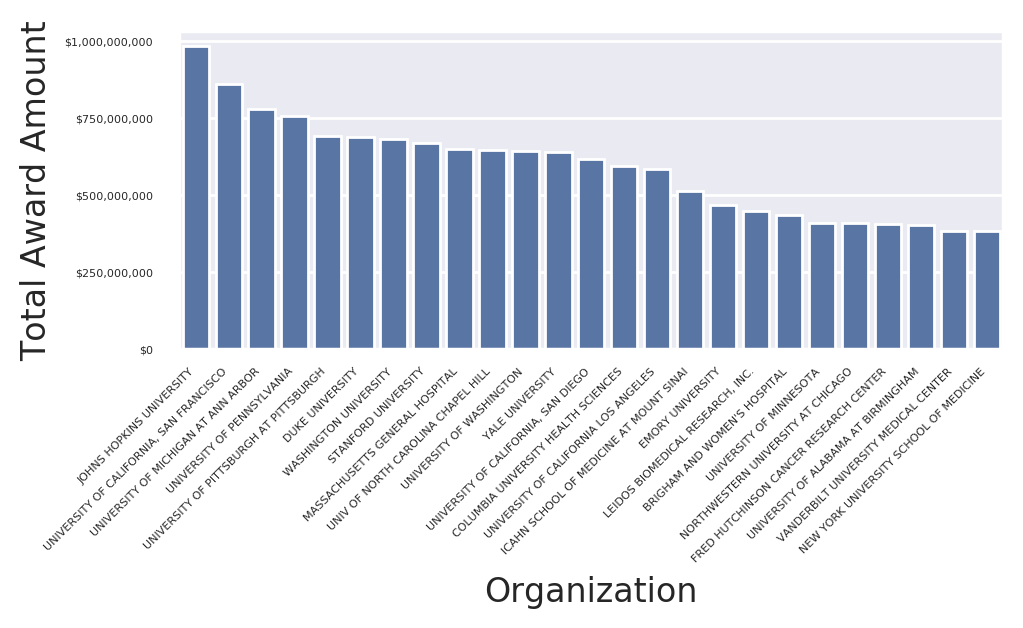

In [124]:
sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(5,3), dpi=200, constrained_layout=True)

ax = sns.barplot(x=df_top_orgs['Organization'][0:25], y=df_top_orgs['Total Award Amount'][0:25], label="Total", color="b", ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(4)
    tick.set_horizontalalignment('right')
    tick.set_y(0.03)

for tick in ax.get_yticklabels():
    tick.set_fontsize(4)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.show()

In [125]:
df_top_orgs.describe()

,Number of Grants,Total Award Amount
count,2846.000000,2.846000e+03
mean,32.892832,1.374302e+07
std,156.401628,6.524272e+07
min,1.000000,1.000000e+00
25%,1.000000,2.891435e+05
50%,2.000000,7.571640e+05
75%,4.000000,2.028070e+06
max,2155.000000,9.853484e+08


# What cities get the most dollar amount in awards?

In [126]:
top_cities = df_min['ORG_CITY'].value_counts()

In [127]:
top_cities_amounts = [get_total_award_amount('ORG_CITY', i, df_min, 'TOTAL_COST').sum() for i in top_cities.index]

In [128]:
d = {'City': top_cities.index.map(lambda x: x.title()), 'Number of Grants': top_cities.values, 'Total Award Amount': top_cities_amounts }
df_top_cities = pd.DataFrame(data=d).sort_values(by=['Total Award Amount'], ascending=False)

In [129]:
df_top_cities.head()

,City,Number of Grants,Total Award Amount
0,Boston,6276,2.825517e+09
1,New York,5851,2.560759e+09
2,Philadelphia,3550,1.412639e+09
5,Seattle,2655,1.370128e+09
3,Baltimore,3036,1.330790e+09


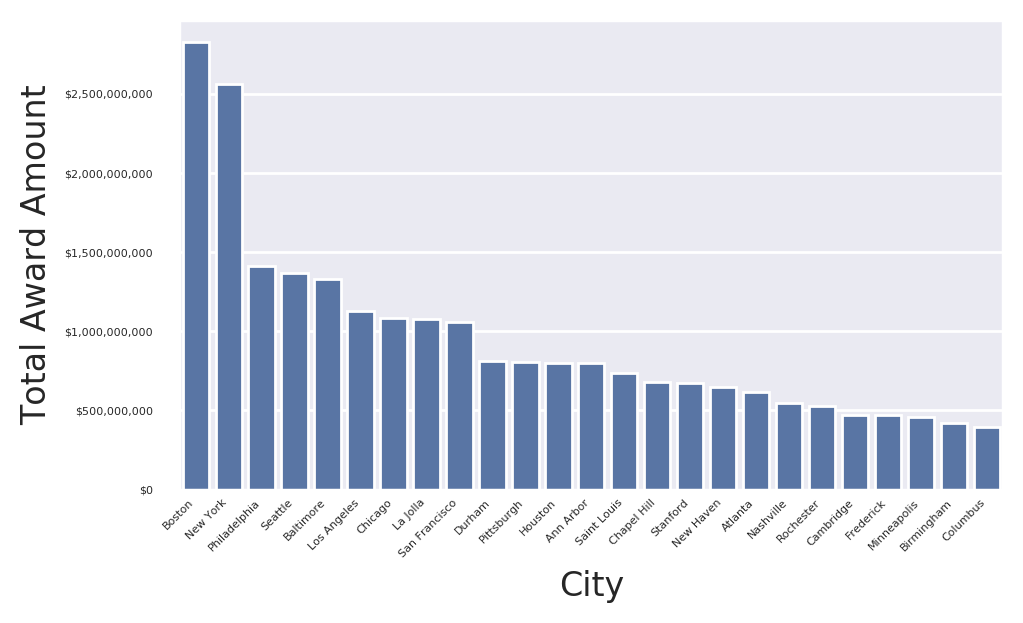

In [130]:
sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(5,3), dpi=200, constrained_layout=True)

ax = sns.barplot(x='City', y='Total Award Amount', data=df_top_cities[0:25], label="Total", color="b", ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(4)
    tick.set_y(0.04)
    tick.set_horizontalalignment('right')
    

for tick in ax.get_yticklabels():
    tick.set_fontsize(4)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
    
plt.show()

In [131]:
def convertToString(x):
    z = ''
    try:
        if (pd.isna(x)):
            z = None
        else: 
            z = x.strftime('%Y-%m-%d')
    except ValueError:
        print(type(x))
        print(x)
        print("Oops!  That was no valid number.  Try again...")
    return z

In [132]:
df_min.shape

(93658, 18)

In [133]:
pd.io.parquet.PyArrowImpl()

ImportError: Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.

In [65]:
%%time
df_min.to_parquet('./data/nih_df_2019')

CPU times: user 271 ms, sys: 55.8 ms, total: 327 ms
Wall time: 441 ms


# Now that we have done some initial processing and visualization, switch over to NIH-2019-awards-Clusters for further analysis.

In [ ]:
%%time
parquet_2019 = './data/nih_df_2019'
df_2019 = pd.read_parquet(parquet_2019)

# Operate on `rows_geo` which only contains rows with a Latitude value

# Precompute pairwise distance

Compute using [haversine_distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html#sklearn.metrics.pairwise.haversine_distances)

In [ ]:
%%time
points = rows_geo.loc[:, ['Latitude', 'Longitude']]
coordinates = np.asarray(points)

In [ ]:
%%time
precomputed = csr_matrix(haversine_distances(np.radians(coordinates)))

In [ ]:
precomputed.todense()

In [ ]:
neighbors.VALID_METRICS['ball_tree']

In [ ]:
%%time


db = DBSCAN(eps=epsilon, min_samples=10,
    metric='precomputed').fit(haversine_distances(np.radians(coordinates))) 

cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))

In [ ]:
num_clusters

In [ ]:
%%time

kms_per_radian = 6371.0088 
epsilon = 4 / kms_per_radian

db = DBSCAN(eps=epsilon, min_samples=15, algorithm='ball_tree',
    metric='haversine').fit(np.radians(coordinates)) 

cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
print(num_clusters)
clusters = pd.Series([coordinates[cluster_labels == n] for n in range( num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

In [ ]:
len(clusters[0])

In [ ]:
num_clusters

In [ ]:
db.core_sample_indices_

In [ ]:
len(db.labels_)

# For each `label_` we get a cluster. There are 9652 labels for each of the 9652 coordinates we passed in.

We can use this to map the projects/costs back to the clusters.

## Create the OPTICS function

`min_samples` is `minPts` the threshold for number of neighbors within radius $\large\varepsilon$

`max_eps` is $\large\varepsilon$

In [ ]:
def GetOptics(num_samples, metric='haversine', max_eps=np.inf):
    return OPTICS(min_samples=num_samples, algorithm='ball_tree', n_jobs=-1, metric=metric, max_eps=max_eps)

In [ ]:
rows_geo.head()

In [ ]:
coordinates = np.asarray(rows_geo[['Latitude', 'Longitude']])

In [ ]:
%%time
optics = None
try:
    optics = GetOptics(10, 'haversine').fit(np.radians(coordinates[:500]))
except RuntimeWarning as err:
    print('whoops')
    print("OS error: {0}".format(err))


In [ ]:
optics

In [ ]:
np.unique(optics.labels_)

In [ ]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians


bsas = [-34.83333, -58.5166646]
paris = [49.0083899664, 2.53844117956]
bsas_in_radians = [radians(_) for _ in bsas]
print(bsas_in_radians)
paris_in_radians = [radians(_) for _ in paris]
result = haversine_distances([bsas_in_radians, paris_in_radians])
final = result * 6371000/1000  # multiply by Earth radius to get kilometers
print(result)
print(result)
print(final)

In [ ]:
tmp = coordinates[:5]
np.radians(tmp)

In [ ]:
tmp

In [ ]:
print([radians(t) for t in tmp[0]])
print(np.radians(tmp[0]))
np.allclose([radians(t) for t in tmp[0]], np.radians(tmp[0]))

In [ ]:
from scipy.sparse import csr_matrix, issparse

In [ ]:
type(result)

In [ ]:
result = haversine_distances(tmp)

In [ ]:
result

In [ ]:
print(csr_matrix(result))

In [ ]:
issparse(result)

In [ ]:
result * 6371000/1000

In [ ]:
replaced['ORG_NAME']
orgs = {value:key for key, value in replaced['ORG_NAME'].items()}

In [ ]:
orgs[73]

In [ ]:
with pd.option_context("display.max_rows", 1000000):
    print(coordinates.tolist())